# < 11. OCR 기술의 개요 >

## 들어가며

### OCR = Text detection + Text recognition

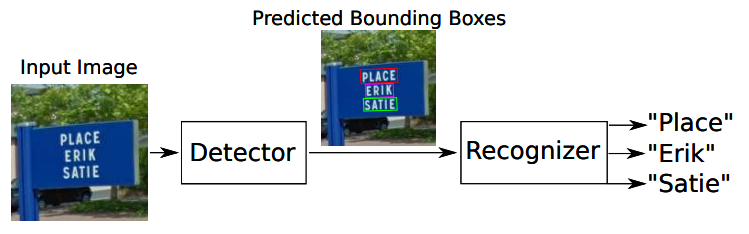
OCR은 크게 문자의 영역을 검출하는 Text detection과 검출된 영역의 문자를 인식하는 Text recognition으로 구분할 수 있습니다. 이 두 과정을 거쳐 이미지 속 문자를 읽게 되죠.

#### Text detection
- 일반적인 Object detection 태스크를 문자 찾아내기로 확장한 버전
- Text detection은 단순히 Object detection 기법뿐 아니라 Segmentation 기법도 동원되며, 문자가 가지는 독특한 특성까지 고려한 형태로 지속적으로 발전

#### Text recognition
- 검출된 영역의 문자가 무엇인지를 인식해 내는 과정
- Text detection을 통해 검출된 문자 영역 속에는 MNIST 데이터처럼 문자 단위로 잘 분리된 텍스트 이미지만 담겨 있는 것이 아닙니다.
- OCR 분야에서 사용하는 독특한 모델 구조에 대해 다루게 될 것

---

## 11.2 Before Deep Learning


### OCR에 활용되기 전 문자 찾아내기
- https://arxiv.org/pdf/1811.06193.pdf
- 위 논문은 브라우저에서 동작하는 OCR을 이용하여 웹에서 유저의 행동을 관찰하는 방법을 제안
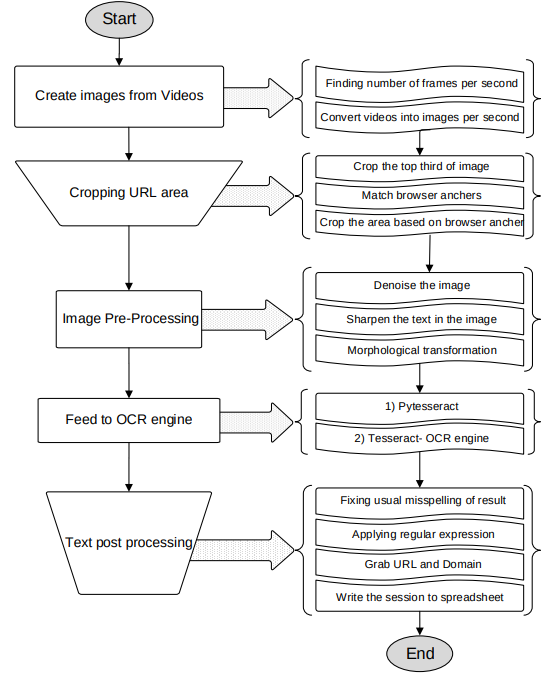

- 위 그림에서 OCR 엔진으로 Tesseract OCR을 사용하려고 하는 것을 확인
    - Tesseract OCR은 1985년 휴렛 패커드 사에서 개발이 시작되어 2005년에는 오픈소스로 출시되었고, 2006년부터는 구글의 후원을 받는 오픈소스 OCR 엔진
- 위 그림은 크게 5단계로 나뉘어 있는데, 위 3단계는 입력 이미지 추출과 전처리, 4번째 단계는 OCR 처리, 마지막 5번째 단계는 OCR의 출력 텍스트의 후처리로 구성

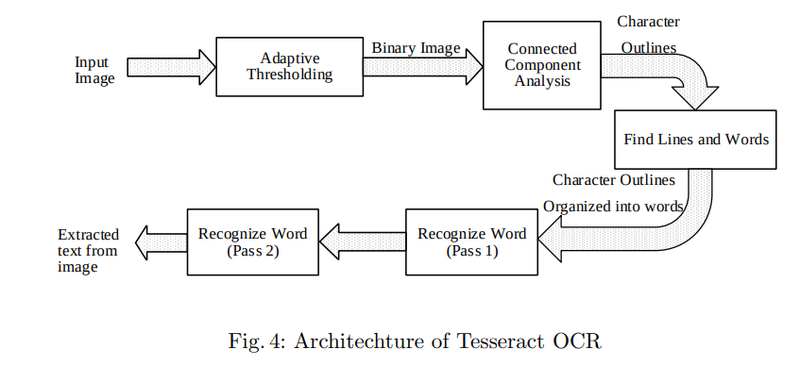

1. Adaptive Thresholding 단계에서 입력 영상의 이진화를 통해 흑백으로 변환
2. Connected Component Analysis 단계에서 문자 영역을 검출
3. Find Lines and Words에서 라인 또는 단어 단위를 추출
4. Recognize Word 단계에서 단어(Word) 단위 이미지를 Text로 변환하기 위해 문자를 하나씩 인식하고 다시 결합하는 과정을 거침



---

## 11.3 Text detection

문자는 몇 개가 모여서 단어 혹은 문장을 이루고 있어서 이미지 내에서 문자를 검출해낼 때엔 검출하기 위한 최소 단위를 정해야 합니다.

예를 들어 이미지 속에서 문장 단위로 위치를 찾겠다 혹은 단어나 글자 단위로 위치를 찾겠다고 정할 수 있습니다. 문장 또는 단어 단위로 찾아낼 경우, 엄청나게 긴 단어나 문장과 함께 짧은 길이도 찾아낼 수 있도록 해야 합니다. 반면 글자 단위로 인식하면 되지 않느냐는 생각을 할 수 있습니다. 이는 글자를 놓치지 않고 찾아내는 데에는 좋을 수 있지만, 글자를 다시 맥락에 맞게 묶어주는 과정을 거쳐야 합니다.

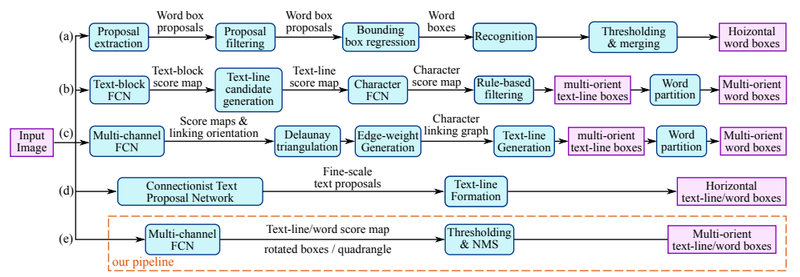

위 그림은 EAST: An Efficient and Accurate Scene Text Detector라는 논문에서 소개된 다양한 Text detection 기법을 정리한 것

2017년 당시에는 Text의 바운딩 박스를 구하는 방식이 주류를 이루었습니다. 위 그림을 보면 가로 방향(Horizontal)으로만 텍스트 박스를 구하는 방식이나 기울어지거나 세로 방향 등의 여러 방향(Multi-oriented)의 텍스트 박스를 구하는 방식이 다양하게 소개되고 있습니다. 해당 논문이 제시하는 (e)의 경우 전체 파이프라인의 길이가 짧고 간결해서 빠르면서도 정확한 Text detection 성능을 보인다고 소개하고 있습니다.

위 그림을 자세히 보면, 위에서 언급한 단어 단위의 탐지와 글자 단위의 탐지가 모두 활용되고 있습니다.
1. 단어 단위의 탐지는 앞서 배운 Object detection의 Regression 기반의 Detection 방법입니다. Anchor를 정의하고 단어의 유무와 Bounding box의 크기를 추정해서 단어를 찾아냅니다. 
2. 글자 단위의 방식은 Bounding box regression을 사용하는 대신 글자 영역을 Segmentation하는 방법으로 접근합니다. 
3. 또한 두 가지 방법을 모두 활용한 방법이 있습니다.

### 1. Regression

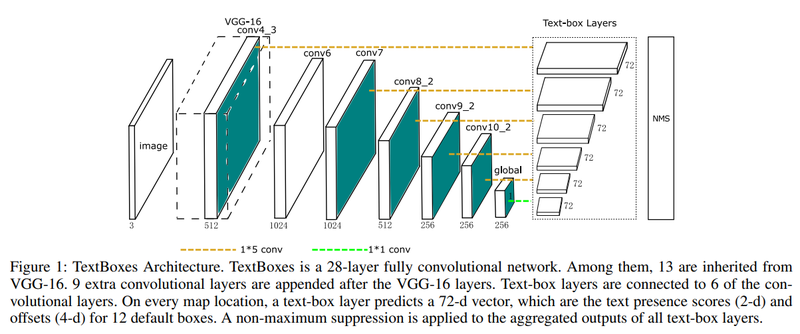

TextBoxes는 2017년 AAAI에 공개된 논문입니다. 이미지 내에서 문자를 찾아내려는 방법에는 다양한 기법들이 활용됩니다.

- TextBoxes 이전에는 글자 단위로 인식한 후 결합하는 방식을 취해 왔지만 위 논문에서는 딥러닝 기반의 Detection을 이용하여 단어 단위로 인식합니다.
- 네트워크의 기본 구조는 SSD: single shot multibox detector를 활용

일반적으로 단어들은 가로로 길기 때문에 Aspect ratio(종횡비)가 큽니다. 이에 따라 몇 가지 변형을 주게 되는데요, 기존의 SSD에서는 Regression을 위한 Convolution layer에서 3x3 크기의 kernel을 갖습니다.

하지만 여기서는 긴 단어의 Feature를 활용하기 위해서 1x5로 convolution filter를 정의하여 사용합니다. Anchor box의 aspect ratio를 1, 2, 3, 5, 7로 만들고, 이에 vertical offset을 적용하여 세로 방향으로 촘촘한 단어의 배열에 대응하도록 했습니다.

### 2. Segmentation

- PixelLink : https://arxiv.org/pdf/1801.01315.pdf
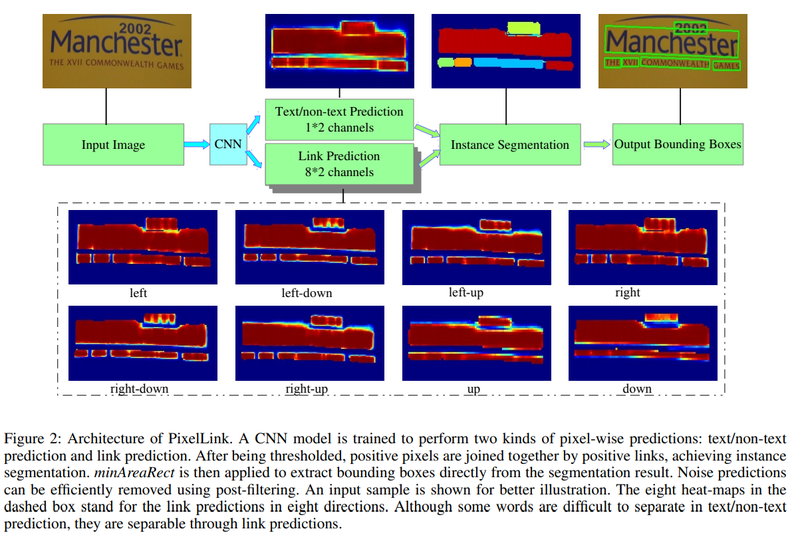

우리는 Semantic segmentation을 이미지 내의 영역을 class로 분리해내는 방법으로 배웠습니다. 이 방법을 문자의 영역을 찾기 위해서 적용하면, 배경과 글자인 영역으로 분리할 수 있습니다. 하지만 문자들은 매우 촘촘히 배열되어있으니 글자 영역으로 찾아낸 뒤에 이를 분리해내는 작업이나 연결하는 작업을 더 해서 원하는 최소단위로 만들어줘야 합니다.

PixelLink는 Text 영역을 찾아내는 segmentation과 함께, 글자가 어느 방향으로 연결되는지를 같이 학습하여 Text 영역 간의 분리 및 연결을 할 수 있는 정보를 추가적으로 활용하고 있습니다.

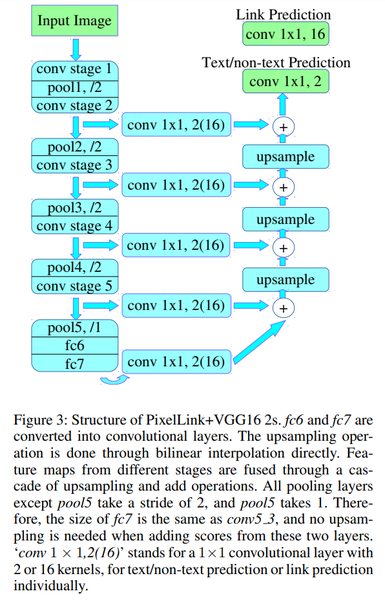
PixelLink의 전체적인 구조는 U-Net과 유사합니다. 하지만 output으로 총 9가지의 정보를 얻습니다.

위 그림의 녹색 부분이 input과 output을 의미하는데, output 중 하나는 Text/non-text Prediction을 위한 class segmentation map으로 해당 영역이 Text인지 Non-text인지 예측값을 의미하는 2개의 커널을 가집니다. 나머지 8가지는 글자의 Pixel을 중심으로 인접한 8개의 Pixel에 대한 연결 여부를 의미하는 16개의 커널로 이루어진 Link Prediction map입니다.

위 그림을 보면 conv 1X1, 2(16) 형태의 레이어가 U-Net 구조로 연결되어, 인접 pixel간 연결 구조가 지속적으로 유지되도록 하는 모델 구조임을 알 수 있습니다.

이를 통해서 인접한 pixel이 중심 pixel과 단어 단위로 연결된 pixel인지, 아니면 분리된 pixel인지 알 수 있으므로, 문자 영역이 단어 단위로 분리된 Instance segmentation이 가능해집니다.



### 3. 최근의 방법들

#### 3.1 CRAFT
- https://arxiv.org/abs/1904.01941
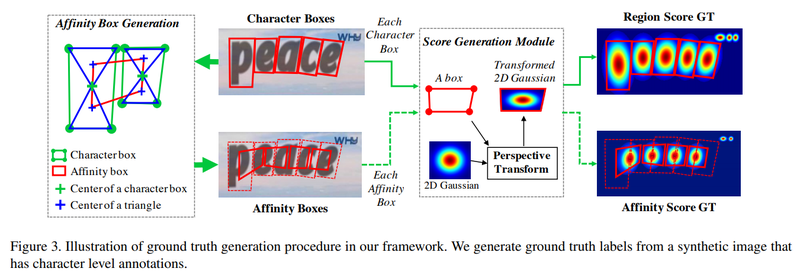

- 문자(Character) 단위로 문자의 위치를 찾아낸 뒤, 이를 연결하는 방식을 Segmentation 기반으로 구현한 방법
- 문자의 영역을 boundary로 명확히 구분하지 않고, 가우시안 분포를 따르는 원형의 score map을 만들어서 배치시키는 방법으로 문자의 영역을 학습
- Weakly supervised learning을 활용
    - 문자 단위 라벨을 가진 데이터셋이 많지 않기 때문에, 단어 단위의 정보만 있는 데이터셋에 대해 단어의 영역에 Inference를 한 후, 얻어진 문자 단위의 위치를 다시 학습에 활용

#### 3.2 
- https://arxiv.org/pdf/1903.11800.pdf
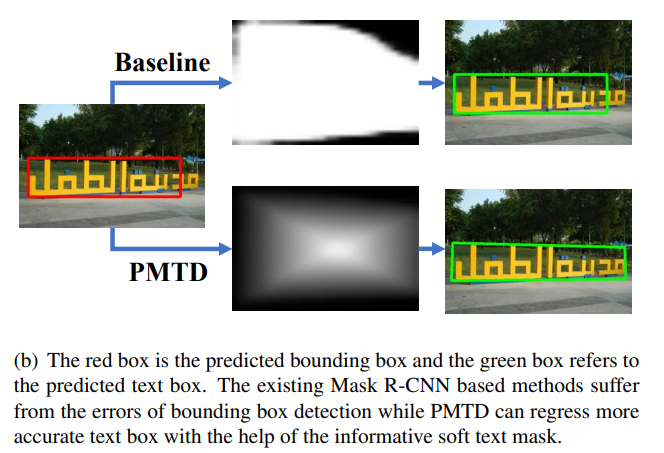

Mask-RCNN의 구조를 활용하여 먼저 Text영역을 Region proposal network로 찾아냅니다. 그다음 Box head에서 더 정확하게 regression 및 classification을 하고 Mask head에서 Instance의 Segmentation을 하는 과정을 거칩니다.

- PMTD는 Mask 정보가 부정확한 경우를 반영하기 위해서 Soft-segmentation을 활용
-  이전의 Mask-RCNN의 경우, 단어 영역이 Box head에 의해 빨간색으로 잡히면 위의 이미지의 baseline처럼 boundary를 모두 Text 영역으로 잡는다
- PMTD는 단어의 사각형 배치 특성을 반영하여 피라미드 형태의 Score map을 활용



---

## 11.4 Text recognition

### 1. Unsegmented Data
- Unsegmented Data : 분리에 드는 비용이 많이 들거나 어려워 Segmentatino이 되어있지 않은 데이터
- 예를 들어, 아래 그림과 같이 annotation이 제대로 안된 음성데이터가 unsegmented data의 한 종류
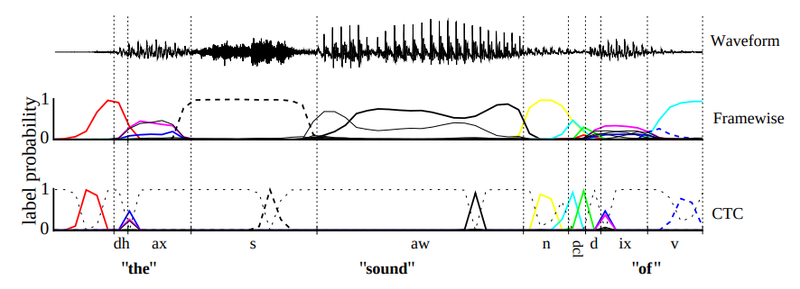



### 2.  CNN과 RNN의 만남 CRNN
- https://arxiv.org/pdf/1507.05717.pdf

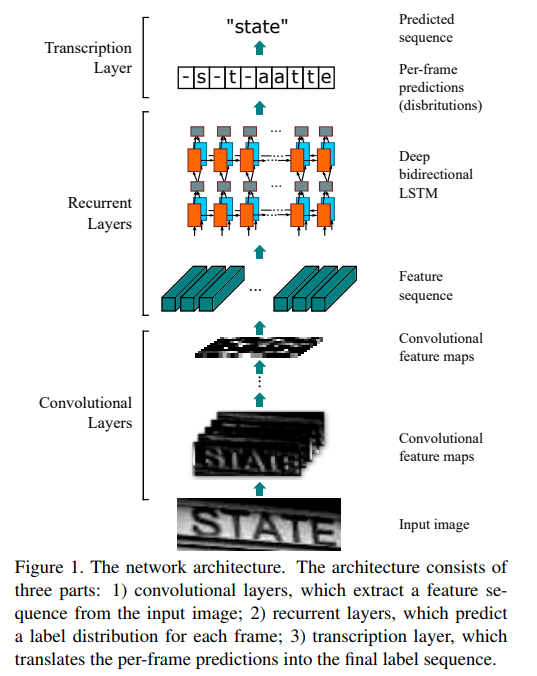
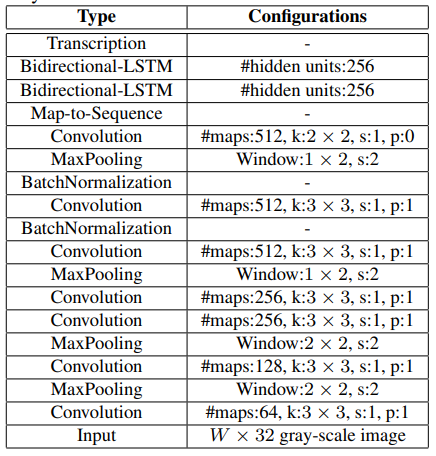

- Unsegmented Data들이 가진 주요한 특징 중 하나는 segment되어 있지 않은 하위 데이터들끼리 시퀀스(sequence)를 이루고 있다는 점
- 연구자들이 생각해 낸 방법 중 하나는 CNN(Convolutional neural network)과 RNN(Recurrent neural network)을 같이 쓰는 방법
- 이러한 모델을 CRNN

문자 이미지에서 정보를 추출하기 위해서는 Feature Extractor가 필요합니다. Feature Extractor로 사용되는 CNN 기반의 VGG 또는 ResNet과 같은 네트워크로부터 문자의 정보를 가진 Feature를 얻어낼 수 있습니다. 이렇게 추출된 Feature를 Map-To-Sequence를 통해 Sequence 형태의 feature로 변환한 후, 다양한 길이의 Input을 처리할 수 있는 RNN으로 넣습니다.

RNN이 Feature로부터 문자를 인식하기 위해서는 문자 영역처럼 넓은 정보가 필요하기 때문에, LSTM으로 구성합니다. 앞의 정보뿐만 아니라 뒤의 정보가 필요하기 때문에 이를 Bidirectional로 구성해서 Bidirectional LSTM을 사용했습니다. Bidirectional LSTM을 사용해 step마다 나오는 결과는 Transcription Layer에서 문자로 변환됩니다.


### 3. CTC
- CRNN에서는 Step마다 Fully connected layer의 logit을 softmax 함수에 넣어줌으로써 어떤 문자일 확률이 높은지 알 수 있다
- 하지만 이 결과 그래도를 문자에 변환하면 기대한 것과 다른 결과가 나온다
    - 왜냐하면 모델의 Output은 24개의 글자로 이루어진 Sequence이지만, 실제 결과는 이와 다르기 때문

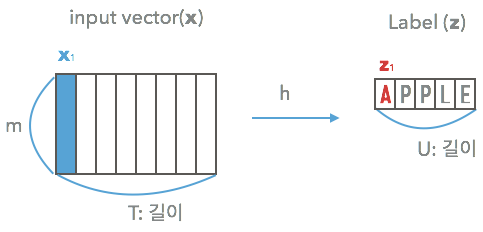

- CRNN에서는 Unsegmentaed Data를 위해 CTC를 활용
- CTC : input과 Output이 서로 다른 Length의 Sequence를 가질 때, 이를 Align 없이 활용하는 방법

위에서 본 "HHHEEELLLOOOOO..."를 "HELLO"로 만들기 위해서는 중복되는 단어인 "HHHH..."나 "EEE...", "LLL..."들을 "H", "E", "L" 등으로 바꿔볼 수 있습니다. 그러면 "HELO"가 될 것입니다. 그렇다면 "L"이 두 번 중복되는 경우에는 어떻게 구분할 수 있을까요?

앞서 봤던 Label Encode에서 이렇게 같은 문자를 구분하기 위한 Blank를 중복된 라벨 사이를 구분하기 위해 넣어줍니다.

아래 그림은 Blank token을 '-'로 대신하여 Output을 만드는 Decoder를 의미합니다. Decode 후에 중복을 제거하고, 인식할 문자가 아닌 값을 지워주면 "HELLO"라는 결과를 얻을 수 있습니다.

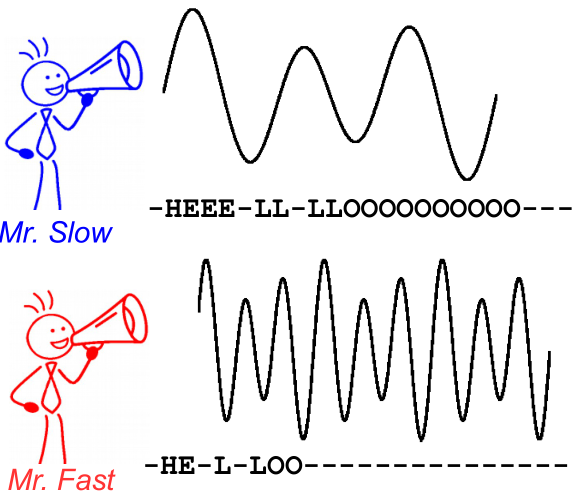

### 4. TPS
- 책이 아닌 거리의 글자를 읽을 때, OCR이 어려워지는 이유는 불규칙한 방향이나 휘어진 진행 방향 때문
- 논문 https://arxiv.org/pdf/1603.03915.pdf 에서는 Thin Plate Spline (TPS) Transformation을 적용하여 입력 이미지를 단어 영역에 맞게 변형 시켜 인식이 잘되도록 해준다


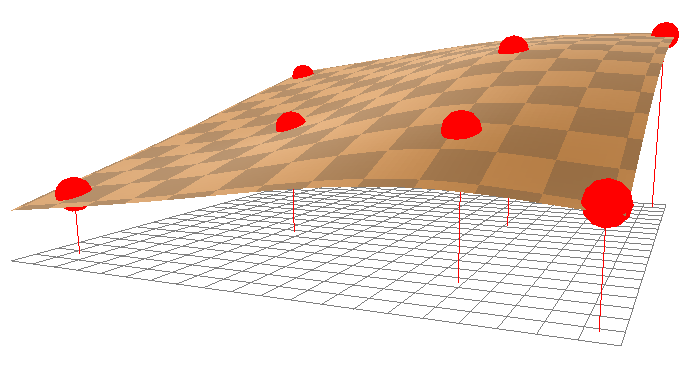

- Thin plate spline은 control point를 정의하고 해당 point들이 특정 위치로 옮겨졌을 때, 축 방향의 변화를 interpolation하여 모든 위치의 변화를 추정
- 이를 통해서 전체 이미지 pixel의 변화를 control point로 만들어낼 수 있다

논문에서는 Control point 20개를 미리 정의합니다. Spatial Transformer Network를 통해서 Control point가 얼마나 움직여야 하는지 예측하는 네트워크를 아래 그림과 같이 Recognition model 앞단에 붙여 입력 이미지를 정방향으로 맞춰줍니다. TPS 연산은 미분 가능한 연산이기 때문에 이 모듈을 Recognition model 앞단에 붙여서 학습이 바로 가능

---

## 11.5 Text recognition + Attention

### 1.  Attention sequence prediction

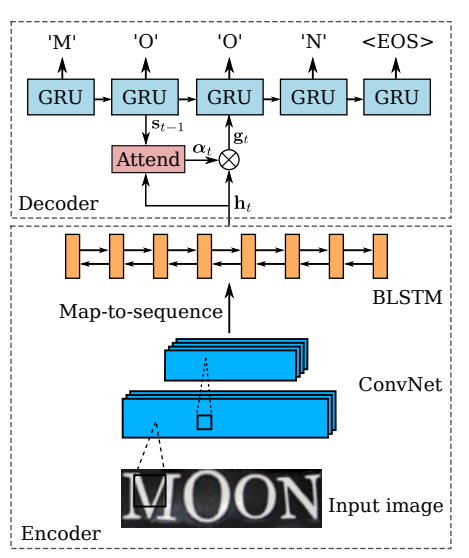

- Attention기반의 sequence prediction은 문장의 길이를 고정하고, 입력되는 Feature에 대한 Attention을 기반으로 해당 글자의 Label을 prediction
-  RNN으로 Character label을 뽑아낸다고 생각하면 되는데, 첫 번째 글자에서 입력 feature에 대한 Attention을 기반으로 label을 추정하고, 추정된 label을 다시 입력으로 사용하여 다음 글자를 추정해내는 방식


이때 20글자를 뽑겠다고 정하게 되면 "YOU"같은 경우에는 3글자를 채우고 빈자리가 문제가 되는데요, 이러한 경우를 위해 미리 정해둔 Token을 사용합니다. 이 Token에는 처음에 사용되는 "start" token과 끝에 사용되는 "end" token이 있습니다. 필요에 따라서 예외처리나 공백을 위한 token을 만들어서 사용하기도 합니다.

### 2. Transformer와 함께!
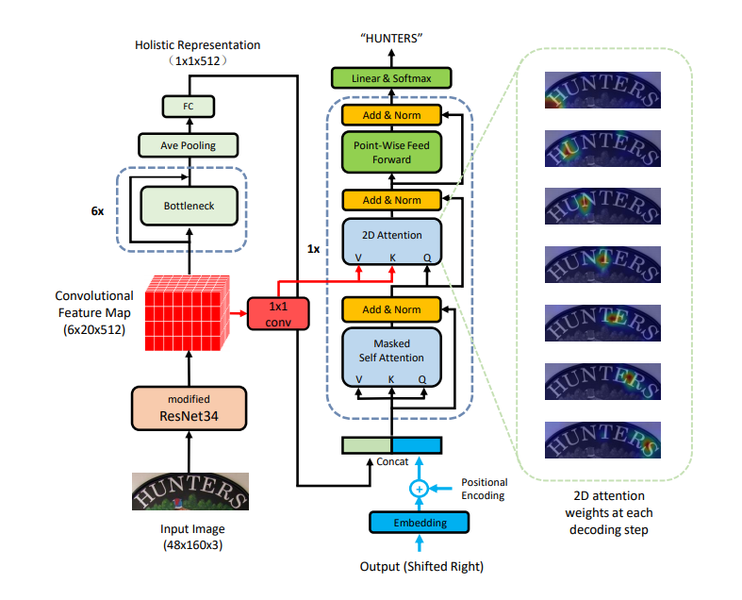

Transformer도 Recognition 모델에 활용되기 시작합니다. 다양한 논문에서 시도되고 있지만 "A Simple and Robust Convolutional-Attention Network for Irregular Text Recognition"가 대표적인 논문입니다.

위 논문에서는 Irregular text를 잘 인식하기 위해서 2d space에 대한 attention을 활용하여 문자를 인식하기 위해 Transformer를 활용합니다.

Transformer는 Query, Key, Value라는 개념을 통해서 Self-Attention을 입력으로부터 만들어냅니다. 이를 통해서 입력에서 중요한 Feature에 대해 Weight를 주게 되죠. Attention의 핵심은 Decoder의 현재 포지션에서 중요한 Encoder의 State에 가중치가 높게 매겨진다는 점입니다.

위에서 Attention이 시각화된 이미지를 눈으로 볼 수 있는데요, Decoder의 각 Step에 따라 입력에 대한 Visual Attention이 시각화된 모습입니다.

